<a href="https://colab.research.google.com/github/ritikpathania/project/blob/main/DenseNet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = '/content/drive/MyDrive/archive.zip'  # Specify the path to the zip file
output_path = '/content/dataset'                # Specify the path to extract the dataset

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

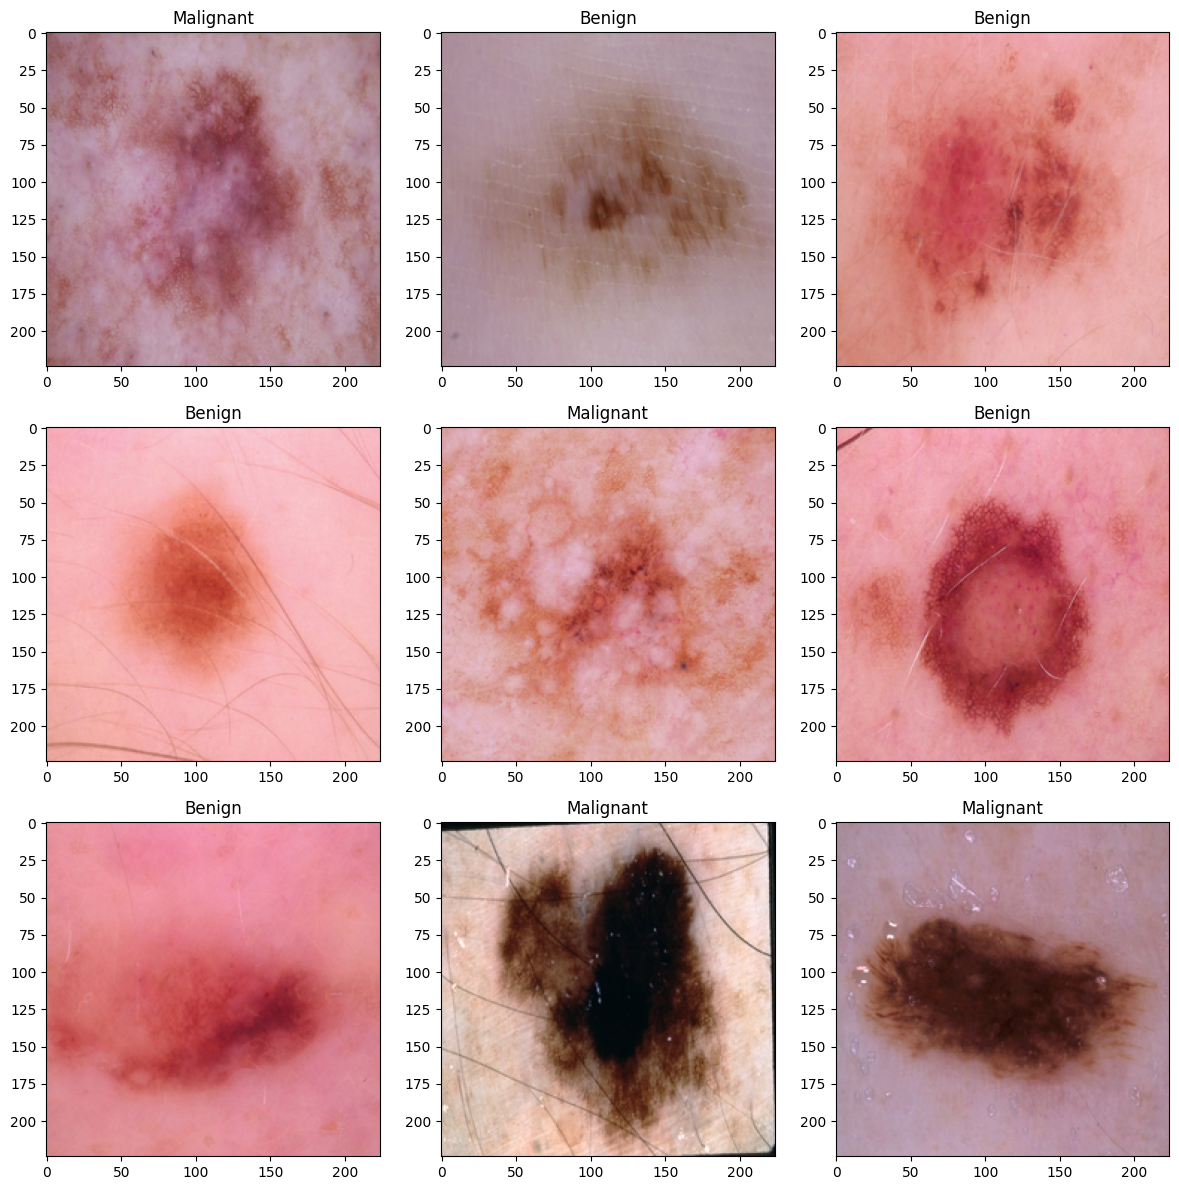

In [39]:
import random

# Define the paths to your directories containing the images
train_benign_dir = '/content/dataset/train/benign'
train_malignant_dir = '/content/dataset/train/malignant'

# Function to display images in a 3x3 grid layout
def display_images_in_grid(benign_dir, malignant_dir):
    # List files within the directories
    benign_img_files = os.listdir(benign_dir)
    malignant_img_files = os.listdir(malignant_dir)

    # Shuffle the image files
    random.shuffle(benign_img_files)
    random.shuffle(malignant_img_files)

    # Create a 3x3 grid layout for displaying images
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    # Initialize counters for image positions in the grid
    positions = [(i, j) for i in range(3) for j in range(3)]
    random.shuffle(positions)
    last_class = ""  # Track the last displayed class

    for i, (row, col) in enumerate(positions):
        if i % 2 == 0:  # Alternate between benign and malignant images
            img_file = benign_img_files.pop(0) if benign_img_files else malignant_img_files.pop(0)
            class_name = "Benign"
        else:
            img_file = malignant_img_files.pop(0) if malignant_img_files else benign_img_files.pop(0)
            class_name = "Malignant"

        img_path = os.path.join(benign_dir if class_name == "Benign" else malignant_dir, img_file)
        img = plt.imread(img_path)
        ax = axes[row, col]
        ax.imshow(img)
        ax.set_title(f"{class_name}")  # Set class name as title

        if last_class == class_name:  # Avoid consecutive images of the same class in a row
            col = (col + 1) % 3
            row += 1 if col == 0 else 0

        last_class = class_name

    plt.tight_layout()
    plt.show()

# Display images in a 3x3 grid layout with random images from benign and malignant directories
display_images_in_grid(train_benign_dir, train_malignant_dir)

In [42]:
# Create a DenseNet121 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the pre-trained DenseNet model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define data generators for train, validation, and test data
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                                   validation_split=0.2  # Splitting the data into 80% training and 20% validation
)

# Data generators for train and validation datasets
train_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',  # Update with the correct path to the 'train' folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Specify subset as 'training' for the training data
)

val_generator = train_datagen.flow_from_directory(
    '/content/dataset/train',  # Update with the correct path to the 'train' folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Specify subset as 'validation' for the validation data
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/dataset/test',  # Update with the correct path to the 'test' folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Train the model with increased epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,  # Increase epochs
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32)

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.
Epoch 1/20
65/65 [==============================] - 150s 878ms/step - loss: 0.4304 - accuracy: 0.7916 - val_loss: 0.7989 - val_accuracy: 0.4941
Epoch 2/20
65/65 [==============================] - 54s 828ms/step - loss: 0.2546 - accuracy: 0.8845 - val_loss: 1.0441 - val_accuracy: 0.5918
Epoch 3/20
65/65 [==============================] - 54s 817ms/step - loss: 0.2147 - accuracy: 0.9095 - val_loss: 1.2522 - val_accuracy: 0.5918
Epoch 4/20
65/65 [==============================] - 53s 812ms/step - loss: 0.1875 - accuracy: 0.9201 - val_loss: 0.6725 - val_accuracy: 0.6797
Epoch 5/20
65/65 [==============================] - 52s 805ms/step - loss: 0.1417 - accuracy: 0.9370 - val_loss: 0.5114 - val_accuracy: 0.8047
Epoch 6/20
65/65 [==============================] - 53s 817ms/step - loss: 0.1343 - accuracy: 0.9466 - val_loss: 0.5968 - val_accuracy: 0.7773
Epoch 7/20
65/65 

In [43]:
model.save('my_model.keras')

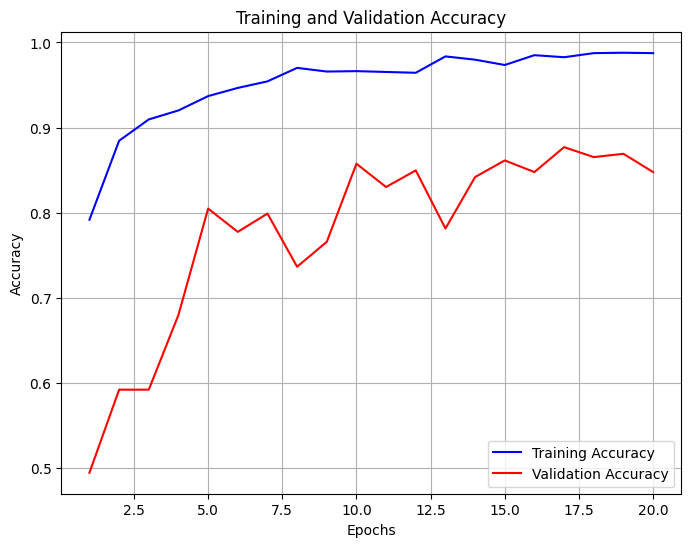

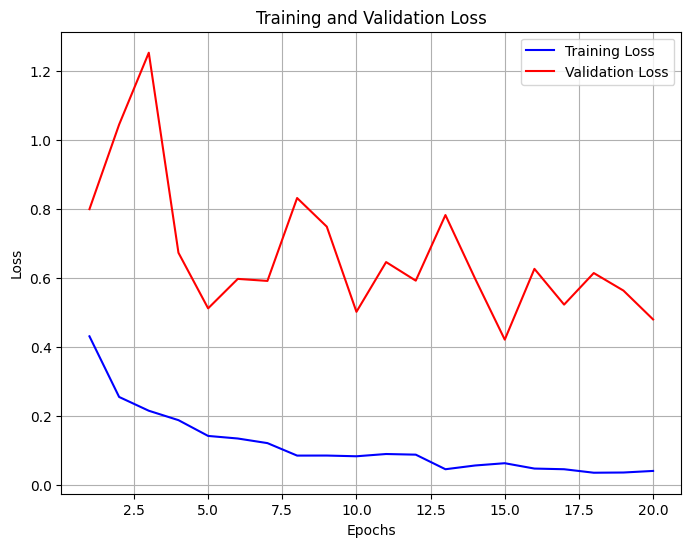

21/21 [==============================] - 7s 327ms/step - loss: 0.3497 - accuracy: 0.8970
Test Accuracy: 0.8969696760177612
21/21 [==============================] - 5s 123ms/step


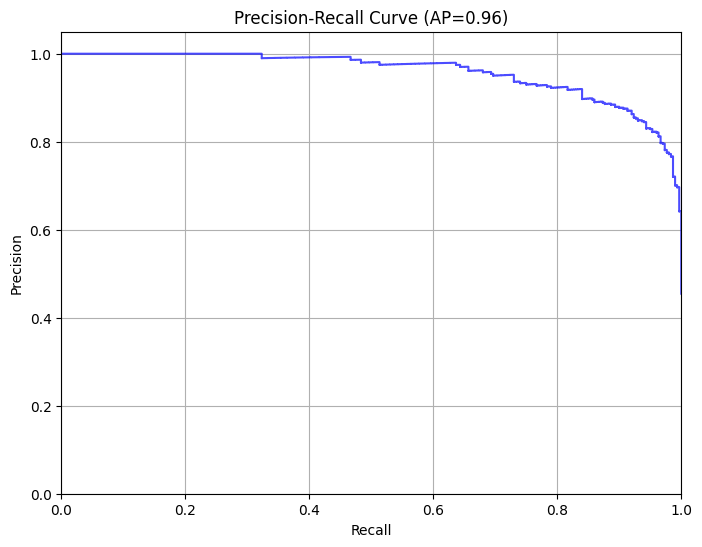

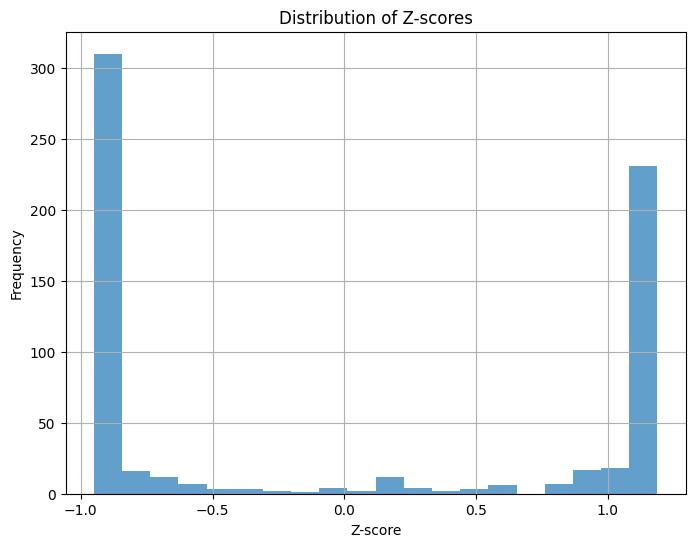

Mean of Predictions: 0.5
Standard Deviation of Predictions: 0.47083842754364014
Confusion Matrix:
[[326  34]
 [ 34 266]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       360
           1       0.89      0.89      0.89       300

    accuracy                           0.90       660
   macro avg       0.90      0.90      0.90       660
weighted avg       0.90      0.90      0.90       660

AUC-ROC: 0.9656018518518519


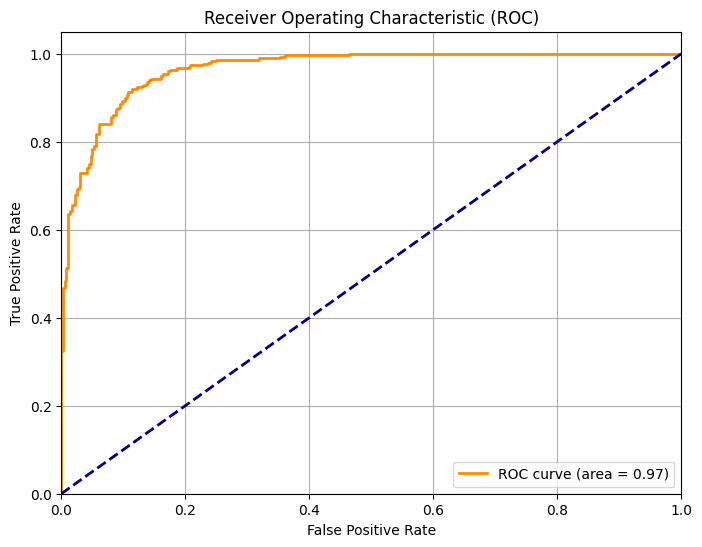

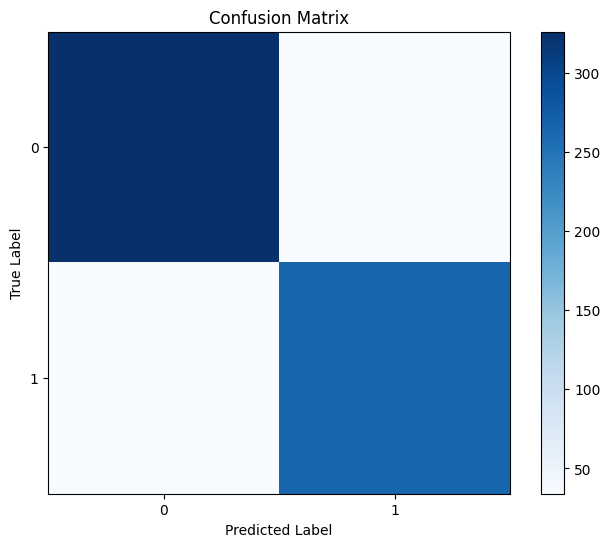

In [44]:
# Extract accuracy and validation accuracy from the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Predict probabilities for the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes

# Get class probabilities
class_probabilities = predictions[:, 1]  # Assuming the positive class is at index 1

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(true_classes, class_probabilities)

# Calculate average precision score
average_precision = average_precision_score(true_classes, class_probabilities)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', alpha=0.7, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:0.2f})'.format(average_precision))
plt.grid()
plt.show()

# Calculate z-scores for class_probabilities
mean_prob = np.mean(class_probabilities)
std_dev_prob = np.std(class_probabilities)
z_scores = (class_probabilities - mean_prob) / std_dev_prob

# Plot z-scores
plt.figure(figsize=(8, 6))
plt.hist(z_scores, bins=20, alpha=0.7)
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-scores')
plt.grid()
plt.show()

# Calculate mean and standard deviation of predictions
mean_predictions = np.mean(predictions)
std_dev_predictions = np.std(predictions)

print(f"Mean of Predictions: {mean_predictions}")
print(f"Standard Deviation of Predictions: {std_dev_predictions}")

# Calculate confusion matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(confusion_mtx)

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes))


# Calculate AUC-ROC
fpr, tpr, thresholds = roc_curve(true_classes, class_probabilities)
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(true_classes)))
plt.xticks(tick_marks, range(len(np.unique(true_classes))))
plt.yticks(tick_marks, range(len(np.unique(true_classes))))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()